# Visualize Model Performance

### Contributors
Professor Foster Provost - NYU Stern School of Business and Carlos Fernandez - teaching assistant

References: 
- Documentation scikit-learn (http://scikit-learn.org/stable/documentation.html)
- Introduction to Machine Learning with Python (http://shop.oreilly.com/product/0636920030515.do)

In [1]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
# Load data
path = "./data/titanic.csv"
df = pd.read_csv(path)[["survived", "pclass", "sex", "age", "fare"]].dropna()
df['survive'] = df.survived.astype(bool)
df.head()

,survived,pclass,sex,age,fare,survive
0,1.0,1.0,female,29.0000,211.3375,True
1,1.0,1.0,male,0.9167,151.5500,True
2,0.0,1.0,female,2.0000,151.5500,False
3,0.0,1.0,male,30.0000,151.5500,False
4,0.0,1.0,female,25.0000,151.5500,False


In [3]:
# create a copy of df and call it df2 so that we can make some transformations and still keep df
df2 = df.copy()
# Transform sex column to a numeric variable
df2["female"] = (df2.sex == "female").astype(int)
df2 = df2.drop("sex", axis="columns")
# Drop outliers. This is to help the visualization in the next examples.
df2 = df2[df2.fare < 400]
# Take a look at the data
df2.head(5)

,survived,pclass,age,fare,survive,female
0,1.0,1.0,29.0000,211.3375,True,1
1,1.0,1.0,0.9167,151.5500,True,0
2,0.0,1.0,2.0000,151.5500,False,1
3,0.0,1.0,30.0000,151.5500,False,0
4,0.0,1.0,25.0000,151.5500,False,1


### Decision Tree Classifier

Rather than build a classifier tree from scratch let's use sklearn's implementation which includes some additional functionality.

In [4]:
from sklearn.model_selection import train_test_split

# Names of different columns
categorical_cols = ["pclass", "female"]
continuous_cols = ["age", "fare"]
target_col = "survived"
predictor_cols = categorical_cols + continuous_cols

X=df2[predictor_cols]
y=df2[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("Population:\n",y.value_counts())
print("Train:\n", y_train.value_counts())
print("Test:\n", y_test.value_counts())

Population:
 0.0    618
1.0    423
Name: survived, dtype: int64
Train:
 0.0    453
1.0    327
Name: survived, dtype: int64
Test:
 0.0    165
1.0     96
Name: survived, dtype: int64


In [5]:
from sklearn.tree import DecisionTreeClassifier

# Let's define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy") 

# Let's tell the model what is the data
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

We now have a classifier tree, let's visualize the results!

### IMPORTANT NOTE 

To use the decision tree visualization code below, you will need to install Graphviz 2.38 on your machine. It is open sourced under the Apache license

In [6]:
# you may also need to install the python graphiz package
!pip install graphviz

In [1]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(decision_tree, out_file="tree.dot", class_names=["dies", "survives"],
                feature_names=predictor_cols, impurity=False, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))


NameError: name 'decision_tree' is not defined

### Confusion Matrix & Accuracy

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, classification_report

print(y_test.value_counts())

# Make predictions against the test set
pred = decision_tree.predict(X_test)

# Show the confusion matrix
''' confusion matrix returned with Predicted as the Columns and Actual as the Rows
         PN  PP
     AN [tn  fp] 
     AP [fn  tp]
'''
print("confusion matrix:")
print(confusion_matrix(y_test, pred))
tn,fp,fn,tp=confusion_matrix(y_test, pred).ravel()
print('tn: ',tn)
print('fp: ',fp)
print('fn: ',fn)
print('tp: ',tp)

# Find the accuracy scores of the predictions against the true classes
print("accuracy: %0.3f" % accuracy_score(y_test, pred))
print("recall: %0.3f" % recall_score(y_test, pred))
print("precision: %0.3f" % precision_score(y_test, pred))
print("f-measure: %0.3f" % fbeta_score(y_test, pred, beta=1))
print(classification_report(y_test,pred))

0.0    165
1.0     96
Name: survived, dtype: int64
confusion matrix:
[[142  23]
 [ 25  71]]
tn:  142
fp:  23
fn:  25
tp:  71
accuracy: 0.816
recall: 0.740
precision: 0.755
f-measure: 0.747
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86       165
         1.0       0.76      0.74      0.75        96

    accuracy                           0.82       261
   macro avg       0.80      0.80      0.80       261
weighted avg       0.82      0.82      0.82       261



Confusion matrix, without normalization
[[142  23]
 [ 25  71]]
Normalized confusion matrix
[[0.86060606 0.13939394]
 [0.26041667 0.73958333]]


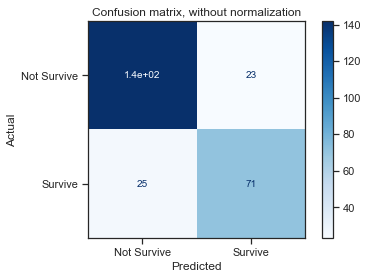

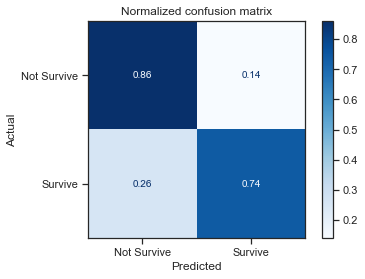

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

negative_label='Not Survive'
positive_label='Survive'

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(decision_tree, X_test, y_test,
                                 display_labels=[negative_label,positive_label],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    disp.ax_.set_xlabel('Predicted')
    disp.ax_.set_ylabel('Actual')

    print(title)
    print(disp.confusion_matrix)

plt.show()

### ROC Curve

#### Function to create ROC curve for one model
__NOTE:__ This will not work with SVC models, as they do not have a predict_proba function

In [13]:
def plot_roc_curve_1 (model, model_name, X_test, y_test):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    from matplotlib import pyplot

    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    cf_probs = model.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    cf_probs = cf_probs[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    cf_auc = roc_auc_score(y_test, cf_probs)

    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(model_name,': ROC AUC=%.3f' % (cf_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    cf_fpr, cf_tpr, _ = roc_curve(y_test, cf_probs)

    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(cf_fpr, cf_tpr, marker='.', label=model_name)

    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')

    # show the legend
    pyplot.legend()

    # show the plot
    pyplot.show()

No Skill: ROC AUC=0.500
Decision Tree : ROC AUC=0.843


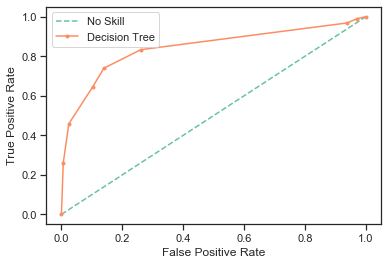

In [14]:
## example ROC plot for the decision tree model using X_test.
plot_roc_curve_1(decision_tree, 'Decision Tree', X_test, y_test)

#### Function to plot ROC curve for a single model using Sklearn new functionality

In [ ]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

def plotNewROCCurve(model, X_test, y_test):
    disp = plot_roc_curve(model, X_test, y_test)
    disp.figure_.suptitle("ROC Curve")
    disp.ax_.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    plt.show()

In [ ]:
## example new ROC plot for decision tree model using X_test.
plotNewROCCurve(decision_tree, X_test, y_test)

### Precision Recall Curve

#### Function to plot Precision Recall Curve for a single model using Sklearn new functionality

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

def plotNewPrecisionRecall(model, X_test, y_test):
    disp = plot_precision_recall_curve(model, X_test, y_test)

In [ ]:
## example new Precision Recall plot for decision tree model using X_test.
plotNewPrecisionRecall(decision_tree, X_test, y_test)